<a href="https://colab.research.google.com/drive/12HEV_BaUZrrboe5PuHNLCcfMWqOnWbCx?usp=sharing" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, confusion_matrix, auc, roc_auc_score, precision_recall_curve, classification_report, precision_score, recall_score, f1_score)
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. 데이터 로드
mon_features25 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mon_25.csv')
mon_label = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mon_label.csv')

# 2. 데이터 전처리
# cumulative_packet_size_seq과 burst_seq 드롭
mon_features_25 = mon_features25.drop(['cumulative_packet_size_seq', 'burst_seq'], axis=1)

#1. Fine tuning 이전

밑의 셀의 실행시간 : 23초

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(mon_features_25, mon_label, test_size=0.3, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# y_train, y_val, y_test를 모두 1차원으로 변환
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

# 검증 데이터 평가
y_valid_pred = rf_model.predict(X_val)

# Validation Accuracy
valid_accuracy = accuracy_score(y_val, y_valid_pred)
print(f"Validation Accuracy: {valid_accuracy:.2f}")

# 테스트 데이터 평가
y_test_pred = rf_model.predict(X_test)

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

Validation Accuracy: 0.75

Test Accuracy: 0.74



Test Confusion Matrix:
[[19  0  0 ...  0  0  2]
 [ 0 15  1 ...  0  0  0]
 [ 0  0 26 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  0  0]
 [ 0  0  0 ...  0 24  0]
 [ 0  0  0 ...  0  0 24]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.72        27
           1       0.58      0.52      0.55        29
           2       0.84      0.90      0.87        29
           3       0.70      0.92      0.79        25
           4       0.82      0.70      0.75        33
           5       0.84      0.89      0.86        18
           6       0.65      0.83      0.73        29
           7       0.73      0.88      0.80        34
           8       0.74      0.58      0.65        24
           9       0.62      0.80      0.70        30
          10       0.71      0.69      0.70        29
          11       0.56      0.67      0.61        21
          12       0.91      0.94      0.92        32
          13       0.52      0.44 

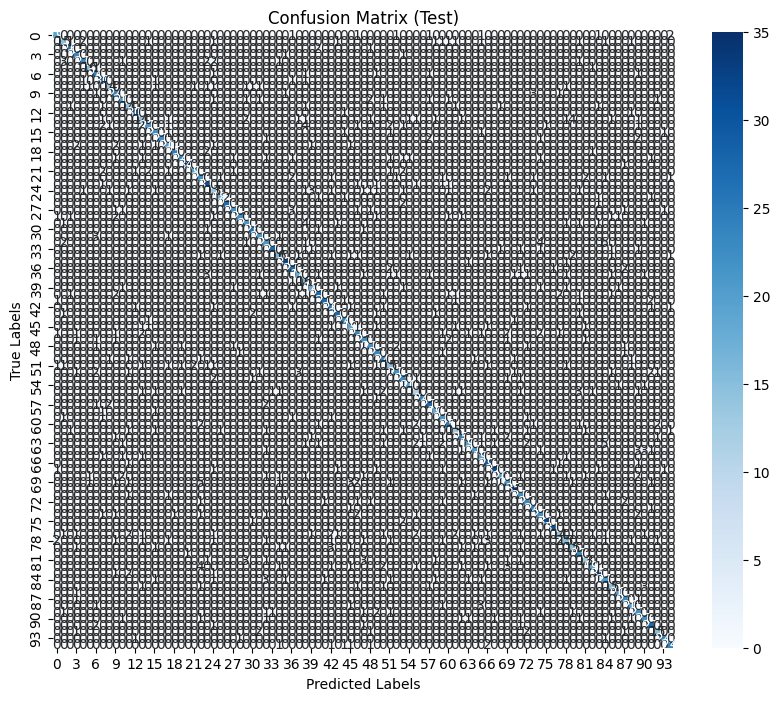

Feature 1 Importance: 0.0567
Feature 2 Importance: 0.0565
Feature 3 Importance: 0.0553
Feature 4 Importance: 0.0568
Feature 5 Importance: 0.0610
Feature 6 Importance: 0.0590
Feature 7 Importance: 0.0579
Feature 8 Importance: 0.0630
Feature 9 Importance: 0.0603
Feature 10 Importance: 0.0599
Feature 11 Importance: 0.0822
Feature 12 Importance: 0.0714
Feature 13 Importance: 0.0000
Feature 14 Importance: 0.0000
Feature 15 Importance: 0.0505
Feature 16 Importance: 0.0000
Feature 17 Importance: 0.0243
Feature 18 Importance: 0.0496
Feature 19 Importance: 0.0289
Feature 20 Importance: 0.0474
Feature 21 Importance: 0.0298
Feature 22 Importance: 0.0000
Feature 23 Importance: 0.0295


In [ ]:
# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Classification Report
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Precision, Recall, F1-Score (Weighted for multi-class)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Gini Importance 계산
feature_importances = rf_model.feature_importances_
for i, importance in enumerate(feature_importances):
    print(f"Feature {i+1} Importance: {importance:.4f}")


#2. Grid Search를 통한 fine tuning

In [ ]:
#Grid Search를 사용한 Fine Tuning

param_grid = {
    'n_estimators': [200, 300, 400],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'min_samples_split': 2, 'n_estimators': 400}


In [ ]:
#Grid Search를 사용한 Fine Tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [600, 1000]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 600}


In [ ]:
# 이미 최적값을 찾은 하이퍼파라미터 고정
fixed_params = {'n_estimators': 600, 'min_samples_split': 2}

# 탐색할 하이퍼파라미터만 설정
param_grid = {
    'max_depth': [10, 20, None],         # 트리 최대 깊이
    'max_features': ['sqrt', 'log2']    # 노드에서 사용할 최대 특징 수
}

# RandomForestClassifier에 고정된 값과 탐색할 파라미터를 결합
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, **fixed_params),
    param_grid,
    cv=3,
    n_jobs=-1,  # 병렬 처리로 속도 향상
    verbose=1   # 진행 상황 출력
)

# 학습
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt'}


#3. Fine Tuning 이후

밑의 셀의 실행시간: 47

SMOTE 적용 X

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(mon_features_25, mon_label, test_size=0.2, random_state=1)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# y_train, y_val, y_test를 모두 1차원으로 변환
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Random Forest 모델
rf_model = RandomForestClassifier(
    n_estimators=600,          # 최적값: 트리 개수
    min_samples_split=2,       # 최적값: 노드 분할 최소 샘플 수
    max_depth=None,            # 최적값: 트리 최대 깊이
    max_features='sqrt',       # 최적값: 노드에서 사용할 최대 특징 수
    oob_score=True,            # OOB(Out-of-Bag) 샘플 사용하여 평가
    random_state=42            # 랜덤 시드
)

# 랜덤 포레스트 모델 학습
rf_model.fit(X_train, y_train)

# 테스트 데이터 평가
y_test_pred = rf_model.predict(X_test)

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

print("OOB Score:", rf_model.oob_score_)


Test Accuracy: 0.76
OOB Score: 0.7655921052631579



Test Confusion Matrix:
[[31  0  0 ...  1  0  0]
 [ 0 24  1 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 31  0  1]
 [ 1  0  0 ...  0 33  0]
 [ 2  0  1 ...  0  0 28]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        40
           1       0.75      0.52      0.62        46
           2       0.81      0.86      0.83        35
           3       0.78      0.86      0.82        36
           4       0.93      0.80      0.86        46
           5       0.83      0.80      0.81        30
           6       0.69      0.83      0.75        42
           7       0.61      0.89      0.73        37
           8       0.74      0.81      0.78        32
           9       0.72      0.76      0.74        50
          10       0.74      0.67      0.71        43
          11       0.83      0.56      0.67        34
          12       0.92      0.94      0.93        35
          13       0.60      0.49 

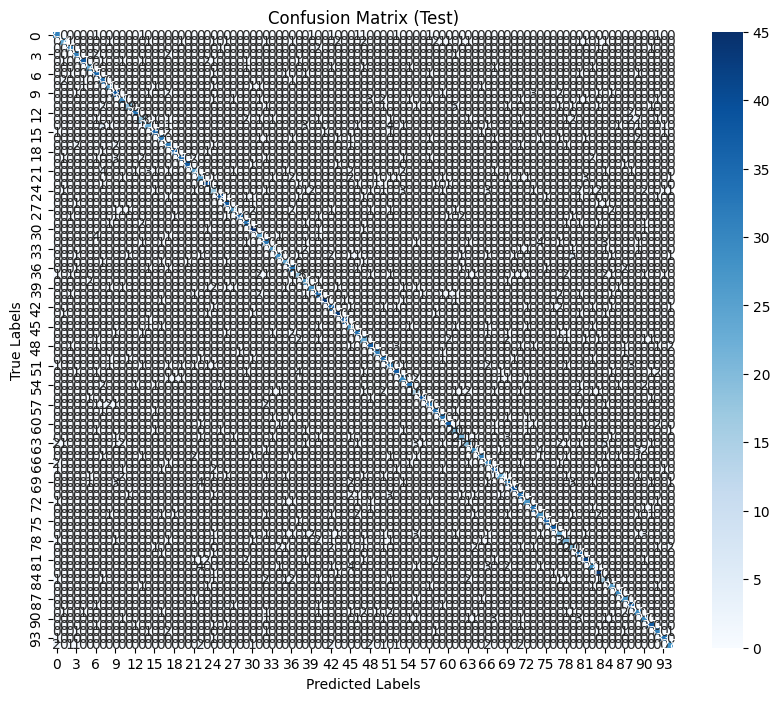

In [ ]:
# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Classification Report
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Precision, Recall, F1-Score (Weighted for multi-class)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

SMOTE 적용 O

In [ ]:
from imblearn.over_sampling import SMOTE

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(mon_features_25, mon_label, test_size=0.3, random_state=1)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# y_train, y_val, y_test를 모두 1차원으로 변환
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Random Forest 모델
rf_model = RandomForestClassifier(
    n_estimators=1000,          # 최적값: 트리 개수
    min_samples_split=2,       # 최적값: 노드 분할 최소 샘플 수
    max_depth=None,            # 최적값: 트리 최대 깊이
    max_features='sqrt',       # 최적값: 노드에서 사용할 최대 특징 수
    oob_score=True,            # OOB(Out-of-Bag) 샘플 사용하여 평가
    random_state=42            # 랜덤 시드
)

# 랜덤 포레스트 모델 학습
rf_model.fit(X_train_smote, y_train_smote)

# 테스트 데이터 평가
y_test_pred = rf_model.predict(X_test)

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

print("OOB Score:", rf_model.oob_score_)


Test Accuracy: 0.75
OOB Score: 0.7814929480564156



Test Confusion Matrix:
[[46  0  0 ...  1  0  2]
 [ 0 31  2 ...  1  0  0]
 [ 0  0 50 ...  0  0  0]
 ...
 [ 0  0  0 ... 43  0  2]
 [ 0  0  0 ...  0 51  0]
 [ 2  0  1 ...  0  0 37]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        60
           1       0.65      0.49      0.56        63
           2       0.81      0.88      0.84        57
           3       0.76      0.86      0.81        58
           4       0.81      0.79      0.80        63
           5       0.91      0.83      0.87        52
           6       0.74      0.88      0.80        56
           7       0.67      0.87      0.75        60
           8       0.82      0.84      0.83        50
           9       0.71      0.79      0.75        68
          10       0.69      0.64      0.67        53
          11       0.72      0.61      0.66        51
          12       0.89      0.94      0.92        52
          13       0.63      0.51 

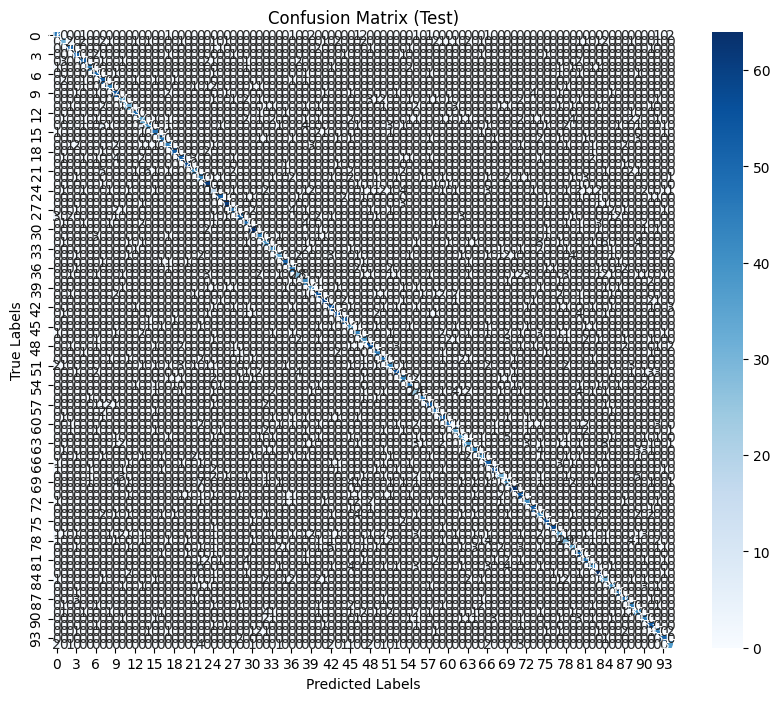

In [ ]:
# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nTest Confusion Matrix:")
print(conf_matrix_test)

# Classification Report
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Precision, Recall, F1-Score (Weighted for multi-class)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1 Score: {test_f1:.2f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()